In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [2]:
# Constants
INNER_RAD = 1e-4 # r1
OUTER_RAD = 1  # r2
DISK_RES = 1400 # pixels per metre
PIX_RADIUS = OUTER_RAD * DISK_RES
NUM_BINS = int(14 * PIX_RADIUS ** (1/3)) # Freedman rule
U_MAX = 5.0 / np.sqrt(OUTER_RAD)
U_MIN = 1e-9
BIN_WIDTH = 2 * U_MAX / NUM_BINS
DELTA_U = 12
SIGMA = DELTA_U / np.sqrt(8 * np.log(2)) # from Wikipedia

In [3]:
# Functions

def get_u(x, y):
    r2 = x**2 + y**2
    # set u = inf for small radius so that it is excluded from the plot
    if r2 < INNER_RAD**2:
        return 0
    if r2 > OUTER_RAD**2:
        return 0
    return x * (r2 ** -0.75)

def get_brightness_shifted(x: float, y: float, alpha: float) -> float:
    r = np.sqrt(x**2 + y**2)
    r_dash = (r + OUTER_RAD) / OUTER_RAD
    if (r > OUTER_RAD):
        return 0.0
    
    # Option 0: smiley face :)
    # if (
    #     (x-OUTER_RAD/3)**2 + (-y-OUTER_RAD/2)**2 <= (OUTER_RAD**2)/35 or
    #     (x- 2*OUTER_RAD/3)**2 + (-y-OUTER_RAD/2)**2 <= (OUTER_RAD**2)/35 or
    #     (
    #         (-y <= OUTER_RAD/8) and 
    #         ((x-OUTER_RAD/2)**2 + (-y-OUTER_RAD/8)**2 <= (OUTER_RAD**2)/8) and
    #         ((x-OUTER_RAD/2)**2 + (-y-OUTER_RAD/8)**2 >= (OUTER_RAD**2)/10)
    #     )
    # ):
    #     return 1
    # return 0.5

    # Option 1: constant
    # return 1

    # Option 2: linear in x
    # return (x + 2*OUTER_RAD) / (4*OUTER_RAD)

    # Option 3: inverse power law:
    # return (r_dash**(-ALPHA))

    # Option 4: combination
    return (((x + 2*OUTER_RAD) / (4*OUTER_RAD)) + (r_dash**(-alpha)))/2

def get_brightness(x: float, y: float, alpha) -> float:
    r = np.sqrt(x**2 + y**2)
    if (r > OUTER_RAD or r < INNER_RAD):
        return 0.0
    
    # Option 1: constant
    # return 1

    # Option 2: linear in x
    # return (x + 2*OUTER_RAD) / (4*OUTER_RAD)

    # Option 3: inverse power law:
    return (r**(-alpha))

    # Option 4: combination
    # return (((x + 2*OUTER_RAD) / (4*OUTER_RAD)) + (r_dash**(-ALPHA)))/2

def make_brightness_grid(alpha: float = 0, is_shifted: bool = False) -> list[list[float, float]]:
    # each coordinate represents the corresponding brightness coordinate on the disk
    brightness_grid = np.zeros((PIX_RADIUS*2, PIX_RADIUS*2))

    for i in range(-PIX_RADIUS, PIX_RADIUS):
        for j in range(-PIX_RADIUS, PIX_RADIUS):
            x = j / DISK_RES
            y = i / DISK_RES
            if is_shifted:
                brightness_grid[i+PIX_RADIUS, j+PIX_RADIUS] = get_brightness_shifted(x, y, alpha)
            else:
                brightness_grid[i+PIX_RADIUS, j+PIX_RADIUS] = get_brightness(x, y, alpha)

    return brightness_grid

def make_u_grid(is_shifted: bool = False) -> list[list[float, float]]:
    # each coordinate represents the corresponding brightness coordinate on the disk
    u_grid = np.zeros((PIX_RADIUS*2, PIX_RADIUS*2))

    for i in range(-PIX_RADIUS, PIX_RADIUS):
        for j in range(-PIX_RADIUS, PIX_RADIUS):
            x = j / DISK_RES
            y = i / DISK_RES
            u_grid[i+PIX_RADIUS, j+PIX_RADIUS] = get_u(x, y)

    return u_grid

def generate_disk_img(data: list[list[float, float]], adjust_contrast: bool = True) -> None:
    if (adjust_contrast):
        vmin_percentile = np.percentile(data, 5)
        vmax_percentile = np.percentile(data, 95)
        plt.imshow(data, cmap='plasma', vmin=vmin_percentile, vmax=vmax_percentile)
    else:
        plt.imshow(data, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.show()

def make_u_intensities(brightness_grid: list[float, float]) -> list[tuple[float, float]]:
    bin_starts = np.linspace(-U_MAX, U_MAX, NUM_BINS, endpoint=False)
    u_intensities = np.zeros((NUM_BINS, 2))
    u_intensities[:, 0] = bin_starts
    for i in range(-PIX_RADIUS, PIX_RADIUS):
        for j in range(-PIX_RADIUS, PIX_RADIUS):
            x = j / DISK_RES
            y = i / DISK_RES
            if (x**2 + y**2 > OUTER_RAD**2):
                continue
            u = get_u(x, y)
            if abs(u) > U_MAX:
                continue
            brightness = brightness_grid[i+PIX_RADIUS, j+PIX_RADIUS]
            #TODO: remove testing
            if (abs(u) <= U_MIN):
                # print(u, brightness, x, y)
                continue
            #
            bin_index = int((u + U_MAX) / BIN_WIDTH)
            if bin_index < 0 or bin_index >= NUM_BINS:
                continue
            u_intensities[bin_index, 1] += brightness

    return u_intensities

def plot_u_intensities(u_intensities: list[tuple[float, float]]) -> None:
    bin_starts = np.linspace(-U_MAX, U_MAX, NUM_BINS, endpoint=False)
    #TODO: remove
    # plt.xkcd()
    #
    plt.plot(bin_starts, u_intensities[:, 1])
    plt.grid(True)
    plt.show()

def plot_mult_intens(
        intens_lst: list[list[tuple[float, float]]],
        labels: list[str] = []
) -> None:
    if (len(intens_lst) != len(labels) and labels != []):
        raise Exception("Length of labels list doesn\'t match")
    
    bin_starts = np.linspace(-U_MAX, U_MAX, NUM_BINS, endpoint=False)

    i = 0
    for u_intensities in intens_lst:
        if labels == []:
            plt.plot(bin_starts, u_intensities[:, 1])
        else:
            plt.plot(bin_starts, u_intensities[:, 1], label=labels[i])
            i += 1
    if (labels != []):
        plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right')
    plt.grid(True)
    plt.show()

def flatten_spike(u_intens: list[tuple[float, float]], n: int) -> list[tuple[float, float]]:
    # average the middle n bins
    indices = np.arange(int((NUM_BINS-n)/2), int((NUM_BINS+n)/2), 1)
    # print(f"middle bit: {u_intens[indices,1]}")
    av = np.mean(u_intens[indices, 1])
    # print(f"indices, av: {indices}, {av}")
    flattened = np.copy(u_intens)
    for i in indices:
        flattened[i] = av
    return flattened

def perf_gauss_smooth(u_intens: list[tuple[float, float]], sigma: float) -> list[tuple[float, float]]:
    old_brightness = u_intens[:,1]
    new_brightness = gaussian_filter1d(old_brightness, sigma)
    smoothed_intens = np.copy(u_intens)
    smoothed_intens[:,1] = new_brightness
    return smoothed_intens

def normalise_u_intens(u_intens: list[tuple[float, float]]) -> list[tuple[float, float]]:
    old_brightness = u_intens[:,1]
    # max_intens = np,max(old_brightness)[0]
    new_brightness = old_brightness / (np.max(old_brightness))
    norm_intens = np.copy(u_intens)
    norm_intens[:,1] = new_brightness
    return norm_intens

def one_minus(x: float) -> float:
    return np.sqrt(1-x**2)

def I_smak(alpha: float, x: float) -> float:
    # print(f"I_smak: {alpha}")
    if alpha == 0:
        return (
            -(x**3 / 4 + 3*x / 8) * one_minus(x) +
            3/8 * np.asin(x)
        )
    elif alpha == 0.5:
        return 1/3 * one_minus(x)**3 - one_minus(x)
    elif alpha == 1.0:
        return -x/2 * one_minus(x) + 1/2 * np.asin(x)
    elif alpha == 1.5:
        return - one_minus(x)
    elif alpha == 2.0:
        return np.asin(x)
    elif alpha == 2.5:
        return np.log((1 - one_minus(x)) / x)
    else:
        raise Exception("alpha should be in 0, 0.5, ..., 2.5")

def F_smak(u: float, alpha: float) -> float:
    x_z = u
    if abs(u) > OUTER_RAD:
        x_z = np.sign(u) * OUTER_RAD
    x_1 = u * np.sqrt(INNER_RAD)
    # print(f"F_smak: {alpha}")
    return (u**(2 * alpha - 5)) * (I_smak(alpha, x_z) - I_smak(alpha, x_1))

def make_smak_intens(alpha: float = 0) -> list[tuple[float, float]]:
    bin_starts = np.linspace(-U_MAX, U_MAX, NUM_BINS, endpoint=False)
    smak_intens = np.zeros((NUM_BINS, 2))
    smak_intens[:, 0] = bin_starts

    for i in range(NUM_BINS):
        u = i * BIN_WIDTH - U_MAX
        # print(f"u = {u} at {i}-th bin")
        # print(f"make_smak_intens: {alpha}")
        smak_intens[i, 1] = F_smak(u, alpha)
    
    return smak_intens

In [ ]:
# Testing

# α = 0 ==> constant disk brightness

bg = make_brightness_grid(is_shifted=False)
u_intens = make_u_intensities(bg)

smak_intens = make_smak_intens()

norm_u_intens = normalise_u_intens(u_intens)
norm_smak_intens = normalise_u_intens(smak_intens)

s_u_intens = perf_gauss_smooth(u_intens, sigma=SIGMA)
s_smak_intens = perf_gauss_smooth(smak_intens, sigma=SIGMA)

s_norm_u_intens = normalise_u_intens(s_u_intens)
s_norm_smak_intens = normalise_u_intens(s_smak_intens)

/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_57149/2841119816.py:208: RuntimeWarning: divide by zero encountered in scalar power
  return (u**(2 * alpha - 5)) * (I_smak(alpha, x_z) - I_smak(alpha, x_1))
/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_57149/2841119816.py:208: RuntimeWarning: invalid value encountered in scalar multiply
  return (u**(2 * alpha - 5)) * (I_smak(alpha, x_z) - I_smak(alpha, x_1))


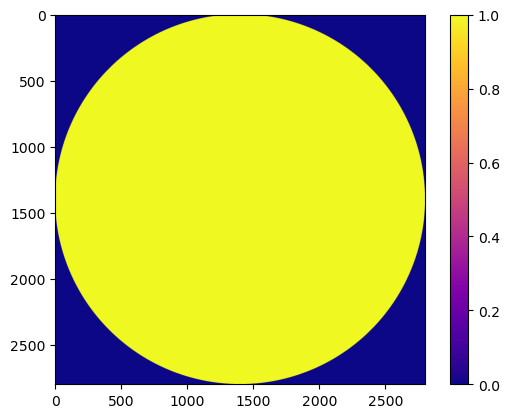

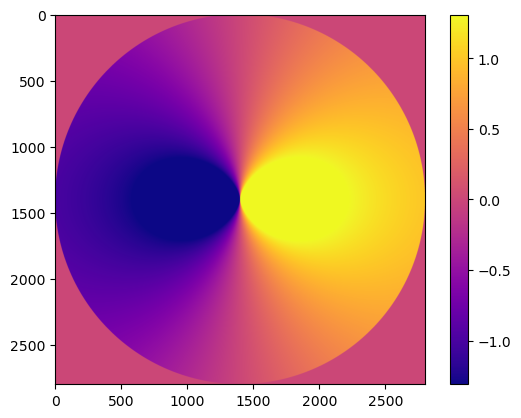

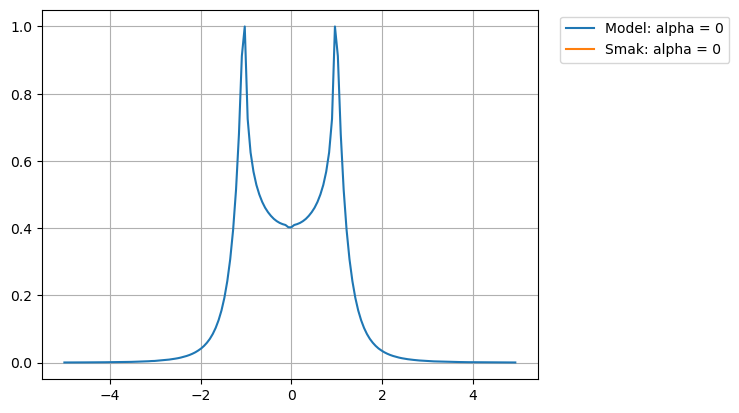

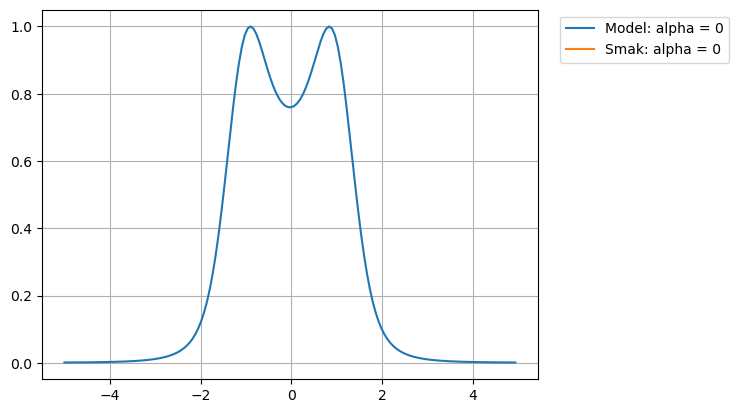

In [5]:
# Plotting tests
generate_disk_img(bg, adjust_contrast=True)
generate_disk_img(make_u_grid(), adjust_contrast=True)

# plot_u_intensities(u_intens)

plot_mult_intens([norm_u_intens, norm_smak_intens], labels=["Model: alpha = 0", "Smak: alpha = 0"])
plot_mult_intens([s_norm_u_intens, s_norm_smak_intens], labels=["Model: alpha = 0", "Smak: alpha = 0"])

In [6]:
# Testing

# α range

alph_step = 0.5
alpha_opts = np.arange(stop=2.5+alph_step, step=alph_step)

bg_alph_range = []
u_intens_alph_range = []

smak_intens_alph_range = []
norm_smak_intens_alph_range = []
norm_u_intens_alph_range = []

# s_u_intens_alph_range = []
# s_smak_intens_alph_range = []

s_norm_u_intens_alph_range = []
s_norm_smak_intens_alph_range = []

for alph in alpha_opts:
    cur_bg = make_brightness_grid(alph)
    cur_u = make_u_intensities(cur_bg)

    cur_smak = make_smak_intens(alph)

    cur_norm_u = normalise_u_intens(cur_u)
    cur_norm_smak = normalise_u_intens(cur_smak)

    cur_s_u = perf_gauss_smooth(cur_u, sigma=SIGMA)
    cur_s_smak = perf_gauss_smooth(cur_smak, sigma=SIGMA)

    cur_s_norm_u = normalise_u_intens(cur_s_u)
    cur_s_norm_smak = normalise_u_intens(cur_s_smak)

    bg_alph_range.append(cur_bg)
    u_intens_alph_range.append(cur_u)
    smak_intens_alph_range.append(cur_smak)
    norm_u_intens_alph_range.append(cur_norm_u)
    norm_smak_intens_alph_range.append(cur_norm_smak)
    # s_u_intens_alph_range.append(cur_s_u)
    # s_smak_intens_alph_range.append(cur_s_smak)
    s_norm_u_intens_alph_range.append(cur_s_norm_u)
    s_norm_smak_intens_alph_range.append(cur_s_norm_smak)



/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_57149/2841119816.py:208: RuntimeWarning: divide by zero encountered in scalar power
  return (u**(2 * alpha - 5)) * (I_smak(alpha, x_z) - I_smak(alpha, x_1))
/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_57149/2841119816.py:208: RuntimeWarning: invalid value encountered in scalar multiply
  return (u**(2 * alpha - 5)) * (I_smak(alpha, x_z) - I_smak(alpha, x_1))
/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_57149/2841119816.py:198: RuntimeWarning: invalid value encountered in log
  return np.log((1 - one_minus(x)) / x)
/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_57149/2841119816.py:198: RuntimeWarning: invalid value encountered in scalar divide
  return np.log((1 - one_minus(x)) / x)


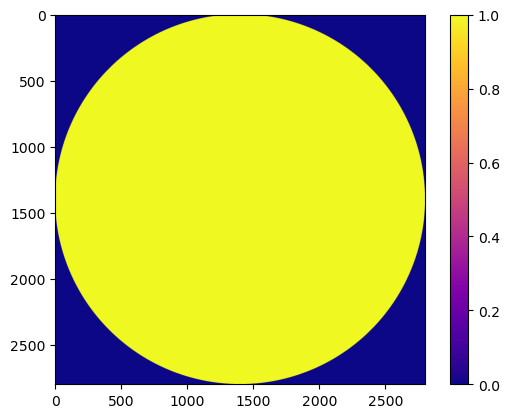

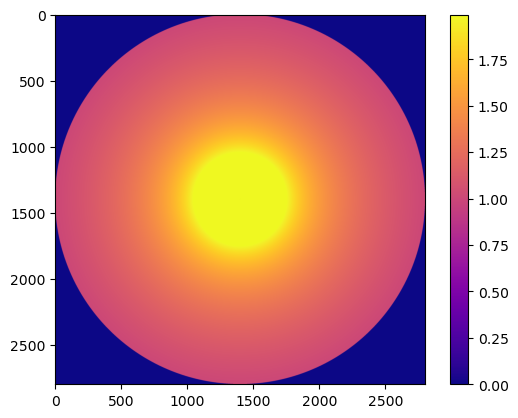

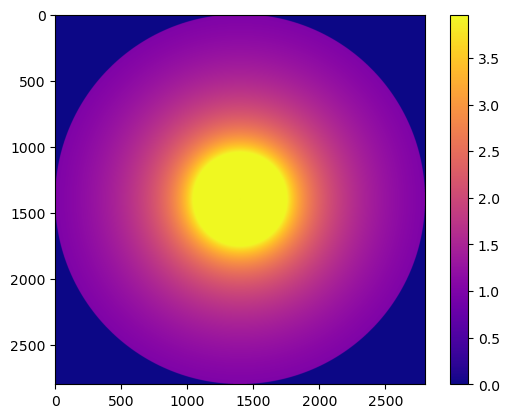

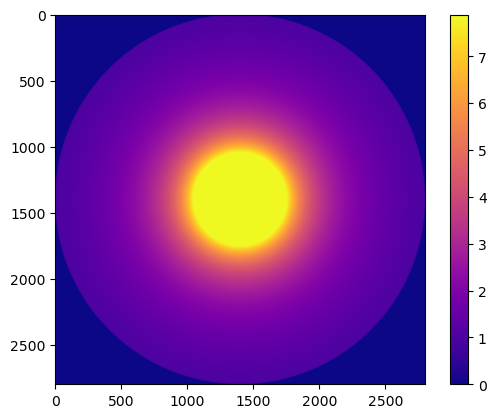

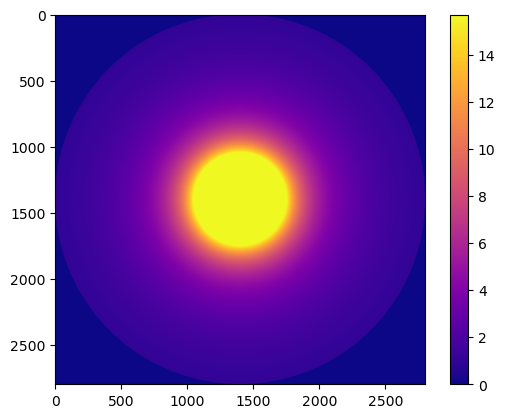

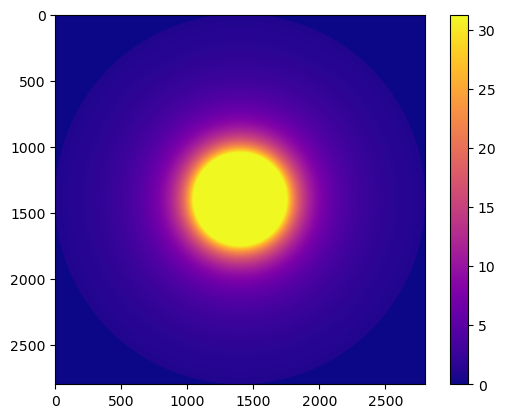

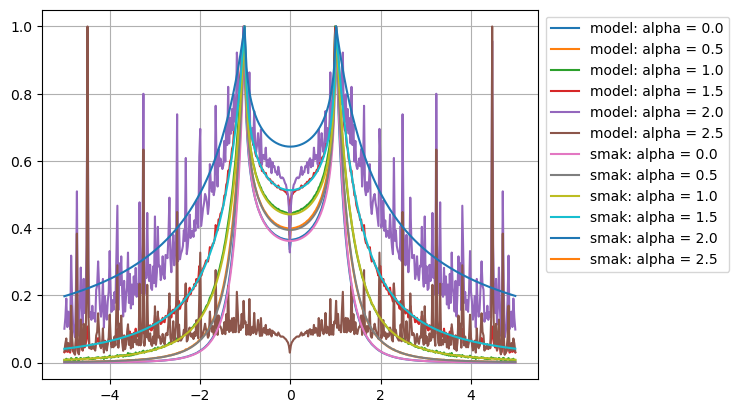

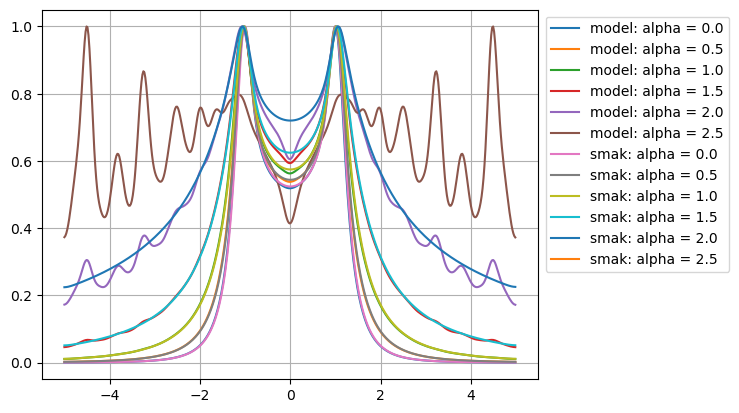

In [48]:
# Plotting tests

num_alphas = len(alpha_opts)
labels = ["model: alpha = "] * num_alphas + ["smak: alpha = "] * num_alphas


for i in range(num_alphas*2):
    labels[i] += f"{alpha_opts[i % num_alphas]}"

    if (i < num_alphas):
        generate_disk_img(bg_alph_range[i], adjust_contrast=True)

plot_mult_intens(norm_u_intens_alph_range + norm_smak_intens_alph_range, labels=labels)
plot_mult_intens(s_norm_u_intens_alph_range + s_norm_smak_intens_alph_range, labels=labels)

In [61]:
# Testing

# α = 2

bg_2 = make_brightness_grid(alpha=2, is_shifted=False)
u_intens_2 = make_u_intensities(bg_2)

smak_intens_2 = make_smak_intens(alpha=2)

norm_u_intens_2 = normalise_u_intens(u_intens_2)
norm_smak_intens_2 = normalise_u_intens(smak_intens_2)

s_u_intens_2 = perf_gauss_smooth(u_intens_2, sigma=SIGMA)
s_smak_intens_2 = perf_gauss_smooth(smak_intens_2, sigma=SIGMA)

s_norm_u_intens_2 = normalise_u_intens(s_u_intens_2)
s_norm_smak_intens_2 = normalise_u_intens(s_smak_intens_2)

/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_27957/2841119816.py:208: RuntimeWarning: divide by zero encountered in scalar power
  return (u**(2 * alpha - 5)) * (I_smak(alpha, x_z) - I_smak(alpha, x_1))
/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_27957/2841119816.py:208: RuntimeWarning: invalid value encountered in scalar multiply
  return (u**(2 * alpha - 5)) * (I_smak(alpha, x_z) - I_smak(alpha, x_1))


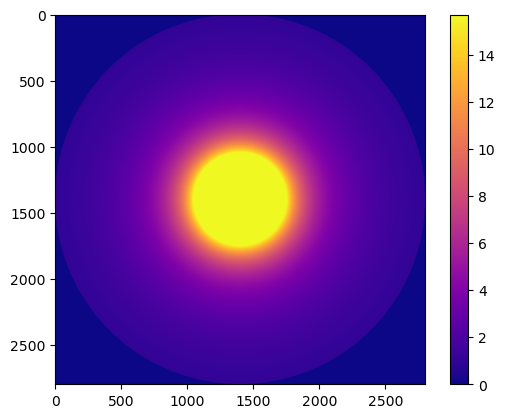

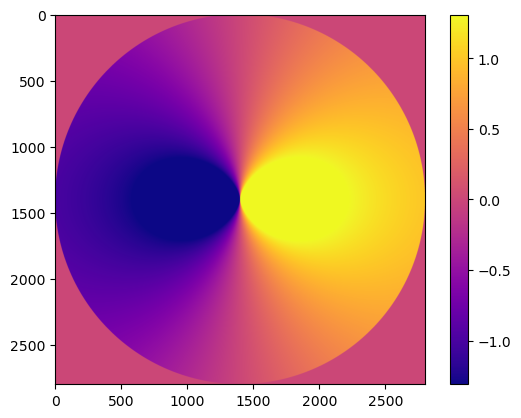

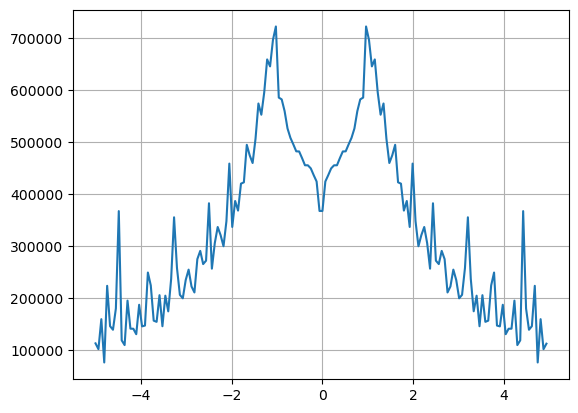

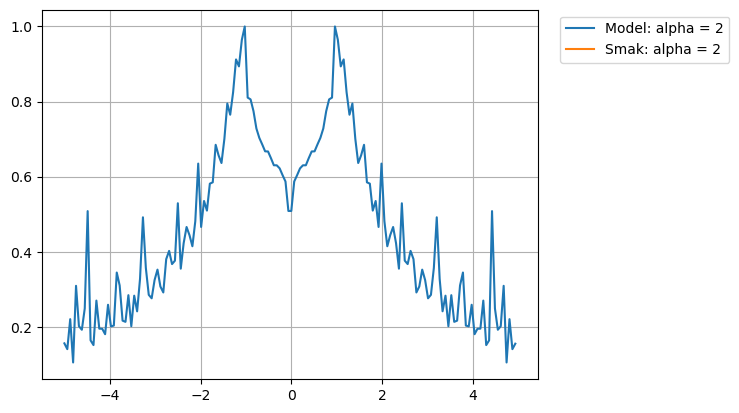

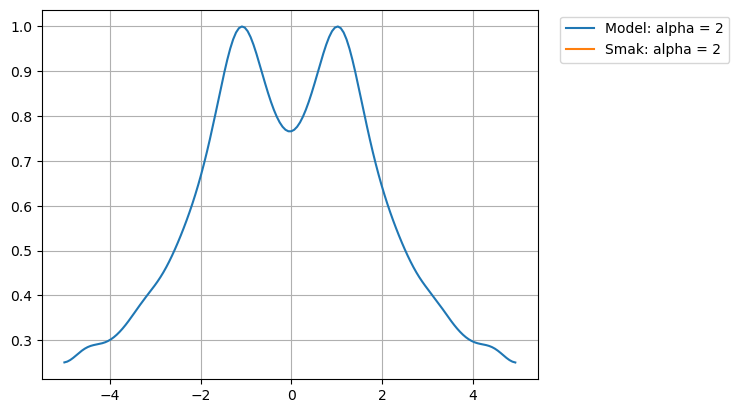

In [62]:
# Plotting tests
generate_disk_img(bg_2, adjust_contrast=True)
generate_disk_img(make_u_grid(), adjust_contrast=True)

plot_u_intensities(u_intens_2)

plot_mult_intens([norm_u_intens_2, norm_smak_intens_2], labels=["Model: alpha = 2", "Smak: alpha = 2"])
plot_mult_intens([s_norm_u_intens_2, s_norm_smak_intens_2], labels=["Model: alpha = 2", "Smak: alpha = 2"])